In [1]:
import pandas as pd
import os
import glob
import io 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
#from brainspace.gradient import GradientMaps
#from sklearn.metrics.pairwise import cosine_similarity
import dill
import nibabel as nib
from math import pi
from scipy.stats import zscore
from PD_features import get_side_affected,get_PD_medication,get_UPDRS,get_any_demo

In [2]:
df = pd.read_table('../participants.tsv')
subjects = df.participant_id.to_list() 
subj = [ s.strip('sub-') for s in subjects ]
out_path = '/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/functional_test/plots/spider_plots/'

def get_average_grad_df(emb_path):
    emb= dill.load(open(emb_path, "rb"))

    emb= emb.mean(axis=2)
    region='striatum'
    gradient_df = pd.DataFrame({region+'_grad_1': emb[:,0], region+'_grad_2': emb[:,1], region+'_grad_3': emb[:,2]})

    return gradient_df

grad_L_m12 = get_average_grad_df('../../derivatives/analysis/functional_test/gradients/bs_emb/aligned_emb_sbctx_LH_Month12.pickle')
grad_R_m12 = get_average_grad_df('../../derivatives/analysis/functional_test/gradients/bs_emb/aligned_emb_sbctx_RH_Month12.pickle')
grad_L_m24 = get_average_grad_df('../../derivatives/analysis/functional_test/gradients/bs_emb/aligned_emb_sbctx_LH_Month24.pickle')
grad_R_m24 = get_average_grad_df('../../derivatives/analysis/functional_test/gradients/bs_emb/aligned_emb_sbctx_RH_Month24.pickle')


grad_L_m12['month'] = 'm12'
grad_L_m24['month'] = 'm24'
df_L_all = grad_L_m12.append(grad_L_m24,ignore_index=True)

grad_R_m12['month'] = 'm12'
grad_R_m24['month'] = 'm24'
df_R_all = grad_R_m12.append(grad_R_m24,ignore_index=True)



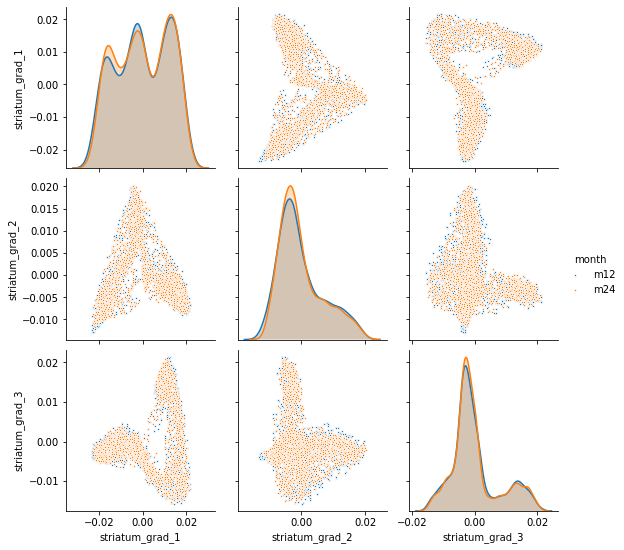

In [3]:
sns_plot = sns.pairplot(df_R_all,plot_kws={"s": 5}, hue="month")
sns_plot.savefig("RH_grads.png")

In [4]:


# Restructure Connectome WB label table
labels_gii = nib.load('../cfg/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii').get_fdata()
labels_txt = pd.read_csv('../cfg/Schaefer2018_1000Parcels_7Networks_order_info.txt',header=None)

df1 = labels_txt[labels_txt.index % 2 != 0].reset_index()
df2 = labels_txt[labels_txt.index % 2 == 0].reset_index()
labels_txt = pd.concat((df1[0].rename('Label'), df2[0].rename('Name')),axis=1) #.columns(['Label','Name'])
labels_txt[['Label','Red','Green','Blue','Alpha']] = labels_txt['Label'].str.split(' ',expand=True)
labels_txt[['Name','Hemisphere','Network','Area','SubArea']] = labels_txt['Name'].str.split('_',expand=True)
networks = labels_txt['Network'].unique()



pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [5]:
def get_conn_matrix(region,matrix_file):
    #subj = ['3119','3120']
    #matrix_dir = '/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/smoothed/corr_matrix/'+session

    matrix = np.load(matrix_file) #np.load(matrix_dir+"/sub-"+subj[0]+"_"+session+"_corr-matrix.npy")

    if region=='ctx':
        sliced_matrix = matrix[:1000,:1000]
    if region=='LH':
        sliced_matrix = matrix[:500,1000:2923]
    if region=='RH':
        sliced_matrix = matrix[500:1000,2923:]


    return sliced_matrix

In [6]:


def get_nets(grad_df,session, hemi, cut='largest',thresh=400,grad='1'):

    if cut == 'largest':
        grad_df_sorted = grad_df.nlargest(400, 'striatum_grad_'+grad)
        grad_df_sorted_ind = list(grad_df_sorted.index.values)

    if cut == 'smallest':
        grad_df_sorted = grad_df.nsmallest(400, 'striatum_grad_'+grad)
        grad_df_sorted_ind = list(grad_df_sorted.index.values)
        
    sub_matrix = []

    for sub in subj:

        df_matrix = get_conn_matrix(hemi,'../../derivatives/analysis/functional_test/corr_matrix/sub-'+sub+'_ses-'+session+'_corr-matrix.npy')
        
        cols_sorted = df_matrix[:, grad_df_sorted_ind]


        
        net_mean = []
        for nets in networks:
        
            net_df = labels_txt.loc[(labels_txt['Network'] == nets) & (labels_txt['Hemisphere'] == hemi)]
            net_inds = list(net_df.index.values)

            if hemi=='LH':
                net_con_df = cols_sorted[net_inds,:]

            if hemi=='RH':
                #net_inds = net_inds - 500
                net_inds[:] = [number - 500 for number in net_inds]
                net_con_df = cols_sorted[net_inds,:] 

            #net_con_df = cols_sorted[net_inds,:]
            net_mean.append(net_con_df.mean())

        sub_matrix.append(net_mean)

    return sub_matrix

#nets_LH_M12 = get_nets(grad_L_m12,'month12', 'LH', cut='smallest')



In [7]:
def get_spider_plots(df1,df2,df3,df4,title):
    
    # number of variable
    categories=networks

    print(categories)
    N = len(categories)
    
    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:

    values1 = df1.values
    values1= np.insert(values1, 7, values1[0])

    values2 = df2.values
    values2= np.insert(values2, 7, values2[0])

    values3 = df3.values
    values3= np.insert(values3, 7, values3[0])

    values4 = df4.values
    values4= np.insert(values4, 7, values4[0])


    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    print(angles)

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, color='black', size=8)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.05,0.1,0.15,0.2], ["0.5","1","1.5","2"], color="grey", size=7)
    plt.ylim(0,0.2)
    
    # Plot data
    ax.plot(angles, values1, linewidth=1, linestyle='solid', color='green')
    ax.plot(angles, values2, linewidth=1, linestyle='dashed', color='green')
    ax.plot(angles, values3, linewidth=1, linestyle='solid', color='blue')
    ax.plot(angles, values4, linewidth=1, linestyle='dashed', color='blue')
    
    # Fill area
    #ax.fill(angles, values1, 'b', alpha=0.1)
    #ax.fill(angles, values2, 'g', alpha=0.1)

    #plt.title(title)
    plt.savefig(out_path+title+'.png', loc='left')

    # Show the graph
    plt.show()

['Vis' 'SomMot' 'DorsAttn' 'SalVentAttn' 'Limbic' 'Cont' 'Default']
[0.0, 0.8975979010256552, 1.7951958020513104, 2.6927937030769655, 3.5903916041026207, 4.487989505128276, 5.385587406153931, 0.0]


FileNotFoundError: [Errno 2] No such file or directory: '/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/functional_test/plots/spider_plots/LH_grad1.png'

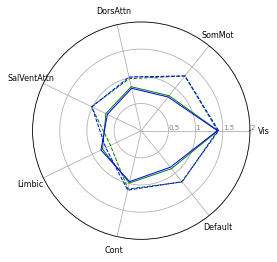

In [8]:
nets_LH_M12_l = get_nets(grad_L_m12,'Month12', 'LH',cut='largest')
nets_LH_M12_s = get_nets(grad_L_m12,'Month12', 'LH', cut='smallest')
nets_LH_M24_l = get_nets(grad_L_m24,'Month24', 'LH',cut='largest')
nets_LH_M24_s = get_nets(grad_L_m24,'Month24', 'LH', cut='smallest')

nets_LH_M12_df_l = pd.DataFrame(nets_LH_M12_l, columns=networks)
nets_LH_M12_df_s = pd.DataFrame(nets_LH_M12_s, columns=networks)
nets_LH_M24_df_l = pd.DataFrame(nets_LH_M24_l, columns=networks)
nets_LH_M24_df_s = pd.DataFrame(nets_LH_M24_s, columns=networks)

mean_nets_LH_M12_df_l = nets_LH_M12_df_l.mean()
mean_nets_LH_M12_df_s = nets_LH_M12_df_s.mean()
mean_nets_LH_M24_df_l = nets_LH_M24_df_l.mean()
mean_nets_LH_M24_df_s = nets_LH_M24_df_s.mean()


get_spider_plots(mean_nets_LH_M12_df_l,mean_nets_LH_M12_df_s,mean_nets_LH_M24_df_l,mean_nets_LH_M24_df_s,'LH_grad1')

['Vis' 'SomMot' 'DorsAttn' 'SalVentAttn' 'Limbic' 'Cont' 'Default']
[0.0, 0.8975979010256552, 1.7951958020513104, 2.6927937030769655, 3.5903916041026207, 4.487989505128276, 5.385587406153931, 0.0]


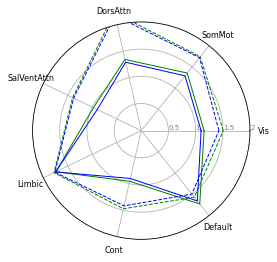

In [ ]:
nets_LH_M12_l = get_nets(grad_R_m12,'Month12', 'RH',cut='largest')
nets_LH_M12_s = get_nets(grad_R_m12,'Month12', 'RH', cut='smallest')
nets_LH_M24_l = get_nets(grad_R_m24,'Month24', 'RH',cut='largest')
nets_LH_M24_s = get_nets(grad_R_m24,'Month24', 'RH', cut='smallest')

nets_LH_M12_df_l = pd.DataFrame(nets_LH_M12_l, columns=networks)
nets_LH_M12_df_s = pd.DataFrame(nets_LH_M12_s, columns=networks)
nets_LH_M24_df_l = pd.DataFrame(nets_LH_M24_l, columns=networks)
nets_LH_M24_df_s = pd.DataFrame(nets_LH_M24_s, columns=networks)

mean_nets_LH_M12_df_l = nets_LH_M12_df_l.mean()
mean_nets_LH_M12_df_s = nets_LH_M12_df_s.mean()
mean_nets_LH_M24_df_l = nets_LH_M24_df_l.mean()
mean_nets_LH_M24_df_s = nets_LH_M24_df_s.mean()


get_spider_plots(mean_nets_LH_M12_df_l,mean_nets_LH_M12_df_s,mean_nets_LH_M24_df_l,mean_nets_LH_M24_df_s,'RH_grad1')

['Vis' 'SomMot' 'DorsAttn' 'SalVentAttn' 'Limbic' 'Cont' 'Default']
[0.0, 0.8975979010256552, 1.7951958020513104, 2.6927937030769655, 3.5903916041026207, 4.487989505128276, 5.385587406153931, 0.0]


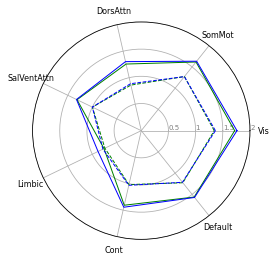

In [ ]:
nets_LH_M12_l = get_nets(grad_L_m12,'Month12', 'LH',cut='largest',grad='2')
nets_LH_M12_s = get_nets(grad_L_m12,'Month12', 'LH', cut='smallest',grad='2')
nets_LH_M24_l = get_nets(grad_L_m24,'Month24', 'LH',cut='largest',grad='2')
nets_LH_M24_s = get_nets(grad_L_m24,'Month24', 'LH', cut='smallest',grad='2')

nets_LH_M12_df_l = pd.DataFrame(nets_LH_M12_l, columns=networks)
nets_LH_M12_df_s = pd.DataFrame(nets_LH_M12_s, columns=networks)
nets_LH_M24_df_l = pd.DataFrame(nets_LH_M24_l, columns=networks)
nets_LH_M24_df_s = pd.DataFrame(nets_LH_M24_s, columns=networks)

mean_nets_LH_M12_df_l = nets_LH_M12_df_l.mean()
mean_nets_LH_M12_df_s = nets_LH_M12_df_s.mean()
mean_nets_LH_M24_df_l = nets_LH_M24_df_l.mean()
mean_nets_LH_M24_df_s = nets_LH_M24_df_s.mean()


get_spider_plots(mean_nets_LH_M12_df_l,mean_nets_LH_M12_df_s,mean_nets_LH_M24_df_l,mean_nets_LH_M24_df_s,'LH_grad2')

['Vis' 'SomMot' 'DorsAttn' 'SalVentAttn' 'Limbic' 'Cont' 'Default']
[0.0, 0.8975979010256552, 1.7951958020513104, 2.6927937030769655, 3.5903916041026207, 4.487989505128276, 5.385587406153931, 0.0]


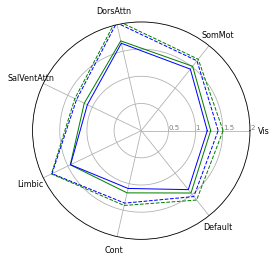

In [ ]:
nets_LH_M12_l = get_nets(grad_R_m12,'Month12', 'RH',cut='largest',grad='2')
nets_LH_M12_s = get_nets(grad_R_m12,'Month12', 'RH', cut='smallest',grad='2')
nets_LH_M24_l = get_nets(grad_R_m24,'Month24', 'RH',cut='largest',grad='2')
nets_LH_M24_s = get_nets(grad_R_m24,'Month24', 'RH', cut='smallest',grad='2')

nets_LH_M12_df_l = pd.DataFrame(nets_LH_M12_l, columns=networks)
nets_LH_M12_df_s = pd.DataFrame(nets_LH_M12_s, columns=networks)
nets_LH_M24_df_l = pd.DataFrame(nets_LH_M24_l, columns=networks)
nets_LH_M24_df_s = pd.DataFrame(nets_LH_M24_s, columns=networks)

mean_nets_LH_M12_df_l = nets_LH_M12_df_l.mean()
mean_nets_LH_M12_df_s = nets_LH_M12_df_s.mean()
mean_nets_LH_M24_df_l = nets_LH_M24_df_l.mean()
mean_nets_LH_M24_df_s = nets_LH_M24_df_s.mean()


get_spider_plots(mean_nets_LH_M12_df_l,mean_nets_LH_M12_df_s,mean_nets_LH_M24_df_l,mean_nets_LH_M24_df_s,'RH_grad2')

['Vis' 'SomMot' 'DorsAttn' 'SalVentAttn' 'Limbic' 'Cont' 'Default']
[0.0, 0.8975979010256552, 1.7951958020513104, 2.6927937030769655, 3.5903916041026207, 4.487989505128276, 5.385587406153931, 0.0]


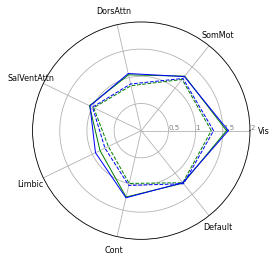

In [ ]:
nets_LH_M12_l = get_nets(grad_L_m12,'Month12', 'LH',cut='largest',grad='3')
nets_LH_M12_s = get_nets(grad_L_m12,'Month12', 'LH', cut='smallest',grad='3')
nets_LH_M24_l = get_nets(grad_L_m24,'Month24', 'LH',cut='largest',grad='3')
nets_LH_M24_s = get_nets(grad_L_m24,'Month24', 'LH', cut='smallest',grad='3')

nets_LH_M12_df_l = pd.DataFrame(nets_LH_M12_l, columns=networks)
nets_LH_M12_df_s = pd.DataFrame(nets_LH_M12_s, columns=networks)
nets_LH_M24_df_l = pd.DataFrame(nets_LH_M24_l, columns=networks)
nets_LH_M24_df_s = pd.DataFrame(nets_LH_M24_s, columns=networks)

mean_nets_LH_M12_df_l = nets_LH_M12_df_l.mean()
mean_nets_LH_M12_df_s = nets_LH_M12_df_s.mean()
mean_nets_LH_M24_df_l = nets_LH_M24_df_l.mean()
mean_nets_LH_M24_df_s = nets_LH_M24_df_s.mean()


get_spider_plots(mean_nets_LH_M12_df_l,mean_nets_LH_M12_df_s,mean_nets_LH_M24_df_l,mean_nets_LH_M24_df_s,'LH_grad3')

['Vis' 'SomMot' 'DorsAttn' 'SalVentAttn' 'Limbic' 'Cont' 'Default']
[0.0, 0.8975979010256552, 1.7951958020513104, 2.6927937030769655, 3.5903916041026207, 4.487989505128276, 5.385587406153931, 0.0]


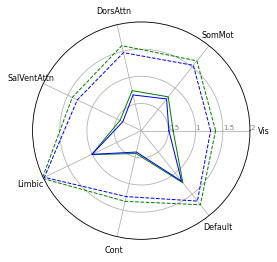

In [ ]:
nets_LH_M12_l = get_nets(grad_R_m12,'Month12', 'RH',cut='largest',grad='3')
nets_LH_M12_s = get_nets(grad_R_m12,'Month12', 'RH', cut='smallest',grad='3')
nets_LH_M24_l = get_nets(grad_R_m24,'Month24', 'RH',cut='largest',grad='3')
nets_LH_M24_s = get_nets(grad_R_m24,'Month24', 'RH', cut='smallest',grad='3')

nets_LH_M12_df_l = pd.DataFrame(nets_LH_M12_l, columns=networks)
nets_LH_M12_df_s = pd.DataFrame(nets_LH_M12_s, columns=networks)
nets_LH_M24_df_l = pd.DataFrame(nets_LH_M24_l, columns=networks)
nets_LH_M24_df_s = pd.DataFrame(nets_LH_M24_s, columns=networks)

mean_nets_LH_M12_df_l = nets_LH_M12_df_l.mean()
mean_nets_LH_M12_df_s = nets_LH_M12_df_s.mean()
mean_nets_LH_M24_df_l = nets_LH_M24_df_l.mean()
mean_nets_LH_M24_df_s = nets_LH_M24_df_s.mean()


get_spider_plots(mean_nets_LH_M12_df_l,mean_nets_LH_M12_df_s,mean_nets_LH_M24_df_l,mean_nets_LH_M24_df_s,'RH_grad3')

In [17]:

df = df.rename(columns={"participant_id": "subj"})
pd_with_updrs = get_UPDRS(df,"MDS-UPDRS_Total","Baseline")


/home/dimuthu1/py3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/scratch/dimuthu1/PPMI_project2/functional_gradients/scripts/PD_features.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PD_demographic_df[sub_ID] = subj


In [9]:
def get_individual_nets(grad_df,sub,session, hemi, cut='largest',thresh=400,grad='1'):
    
    if cut == 'largest':
        grad_df_sorted = grad_df.nlargest(400, 'striatum_grad_'+grad)
        grad_df_sorted_ind = list(grad_df_sorted.index.values)

    if cut == 'smallest':
        grad_df_sorted = grad_df.nsmallest(400, 'striatum_grad_'+grad)
        grad_df_sorted_ind = list(grad_df_sorted.index.values)


    df_matrix = get_conn_matrix(hemi,'../../derivatives/analysis/functional/corr_matrix/sub-'+sub+'_ses-'+session+'_corr-matrix.npy')
 
    cols_sorted = df_matrix[:, grad_df_sorted_ind]
    
    net_mean = []
    for nets in networks:
    
        net_df = labels_txt.loc[(labels_txt['Network'] == nets) & (labels_txt['Hemisphere'] == hemi)]
        net_inds = list(net_df.index.values)
        if hemi=='LH':
            net_con_df = cols_sorted[net_inds,:]

        if hemi=='RH':
            #net_inds = net_inds - 500
            net_inds[:] = [number - 500 for number in net_inds]
            net_con_df = cols_sorted[net_inds,:] 
             
        #print(net_inds)
        net_con_df = cols_sorted[net_inds,:]
        net_mean.append(net_con_df.mean())


    return net_mean


In [10]:


def get_subj_net_df(emb,ses,hemi,grad_n):

    emb = dill.load(open(emb, "rb"))

    sub_nets_l = []
    sub_nets_s = []

    for i,sub in enumerate(subj):

        region='striatum'
        gradient_df = pd.DataFrame({region+'_grad_1': emb[:,0,i], region+'_grad_2': emb[:,1,i], region+'_grad_3': emb[:,2,i]})
        nets_l = get_individual_nets(gradient_df,sub,ses, hemi,cut='largest',grad=grad_n)
        sub_nets_l.append(nets_l)

        gradient_df = pd.DataFrame({region+'_grad_1': emb[:,0,i], region+'_grad_2': emb[:,1,i], region+'_grad_3': emb[:,2,i]})
        nets_s = get_individual_nets(gradient_df,sub,ses, hemi,cut='smallest',grad=grad_n)
        sub_nets_s.append(nets_s)

    nets_df_l = pd.DataFrame(sub_nets_l, columns=networks)
    nets_df_s = pd.DataFrame(sub_nets_s, columns=networks)

    return nets_df_l,nets_df_s



In [11]:
emb_M12_L = "../../derivatives/analysis/functional/gradients/bs_emb/aligned_emb_sbctx_LH_Month12.pickle"
M12_LH_grad1_l,M12_LH_grad1_s = get_subj_net_df(emb_M12_L,'Month12','LH','1')
M12_LH_grad2_l,M12_LH_grad2_s = get_subj_net_df(emb_M12_L,'Month12','LH','2')
M12_LH_grad3_l,M12_LH_grad3_s = get_subj_net_df(emb_M12_L,'Month12','LH','3')

emb_M12_R = "../../derivatives/analysis/functional/gradients/bs_emb/aligned_emb_sbctx_RH_Month12.pickle"
M12_RH_grad1_l,M12_RH_grad1_s = get_subj_net_df(emb_M12_R,'Month12','RH','1')
M12_RH_grad2_l,M12_RH_grad2_s = get_subj_net_df(emb_M12_R,'Month12','RH','2')
M12_RH_grad3_l,M12_RH_grad3_s = get_subj_net_df(emb_M12_R,'Month12','RH','3')

In [12]:
def remove_outliers(df):
    z_scores = zscore(df)

    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    new_df = df[filtered_entries]

    return new_df

In [13]:

#result = pd.concat([pd_with_updrs, M12_RH_grad1_l], axis=1)


#df = result.drop(['subj', 'group','age_at_baseline'], axis = 1)
#df = remove_outliers(df)

#flatening the df so that I can make plots with hue
def get_flat_df(df):
    data =[]
    df_o = pd.DataFrame(data, columns=['MDS-UPDRS_Total', 'network', 'net_label'])

    for i in networks:
        df_i = df.loc[:,['MDS-UPDRS_Total',i]]
        df_i = df_i.rename(columns={i: "network"})
        df_i['net_label'] = i
        #print(df_i)
        df_o = pd.concat([df_o,df_i],ignore_index=True)
    

    return df_o

#df = get_flat_df(df)
"""
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df, col="net_label", hue="net_label", palette="tab20c",
                     col_wrap=4, height=3)

# Draw a horizontal line to show the starting point
#grid.refline(y=0, linestyle=":")

# Draw a line plot to show the trajectory of each random walk
grid.map(sns.regplot, "MDS-UPDRS_Total", "network", marker="o")

# Adjust the tick positions and labels
#grid.set(xticks=np.arange(5), yticks=[-3, 3],xlim=(-.5, 4.5), ylim=(-3.5, 3.5))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)"""

"""#df = df.set_index('MDS-UPDRS_Total')
ax = df.plot(kind="scatter", x="MDS-UPDRS_Total",y=networks[6], color="b", label="a vs. x")
#df.plot(kind="scatter",x="MDS-UPDRS_Total",y=networks[1], color="r", label="b vs. x", ax=ax)
#df.plot(kind="scatter", x="MDS-UPDRS_Total",y=networks[2], color="g", label="c vs. x", ax=ax)
#df.plot( kind="scatter",x="MDS-UPDRS_Total",y=networks[3], color="orange", label="b vs. d", ax=ax)
#df.plot(kind="scatter", x="MDS-UPDRS_Total",y=networks[4], color="purple", label="x vs. a", ax=ax)

ax.set_xlabel("horizontal label")
ax.set_ylabel("vertical label")
plt.show()"""

'#df = df.set_index(\'MDS-UPDRS_Total\')\nax = df.plot(kind="scatter", x="MDS-UPDRS_Total",y=networks[6], color="b", label="a vs. x")\n#df.plot(kind="scatter",x="MDS-UPDRS_Total",y=networks[1], color="r", label="b vs. x", ax=ax)\n#df.plot(kind="scatter", x="MDS-UPDRS_Total",y=networks[2], color="g", label="c vs. x", ax=ax)\n#df.plot( kind="scatter",x="MDS-UPDRS_Total",y=networks[3], color="orange", label="b vs. d", ax=ax)\n#df.plot(kind="scatter", x="MDS-UPDRS_Total",y=networks[4], color="purple", label="x vs. a", ax=ax)\n\nax.set_xlabel("horizontal label")\nax.set_ylabel("vertical label")\nplt.show()'

In [14]:


def get_cor_plots(df):
    g = sns.lmplot(x='MDS-UPDRS_Total', y='network', data=df,
                col='net_label', height=3, aspect=1)

    def annotate(data, **kws):
        r, p = sp.stats.pearsonr(data['MDS-UPDRS_Total'], data['network'])
        ax = plt.gca()
        ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
                transform=ax.transAxes)
        
    g.map_dataframe(annotate)
    plt.suptitle('Season Winners Goal and Win Regression', fontsize = 8)
    plt.show()

In [15]:
def get_final_plots(df):
    df_concated = pd.concat([pd_with_updrs, df], axis=1)
    df_sorted = df_concated.drop(['subj', 'group','age_at_baseline'], axis = 1)
    df_sorted = remove_outliers(df_sorted)
    df_flat = get_flat_df(df_sorted)
    get_cor_plots(df_flat)

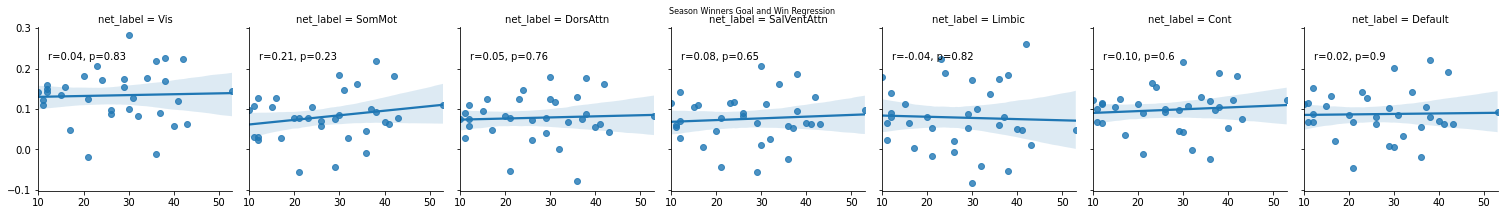

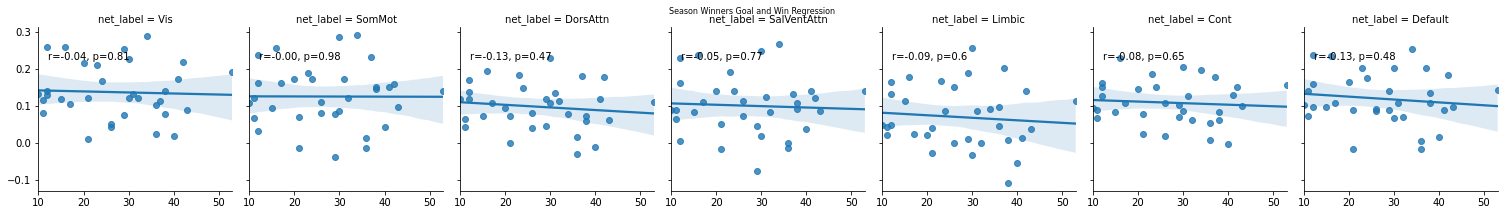

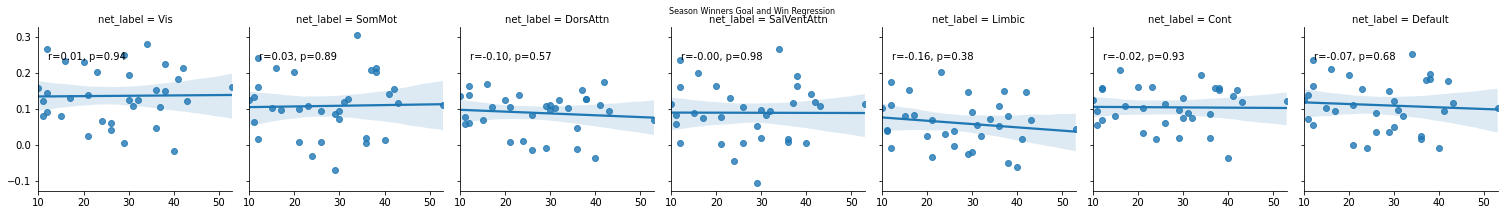

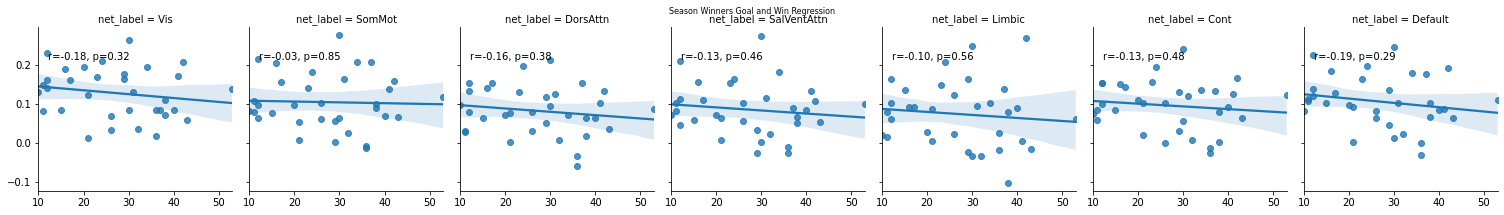

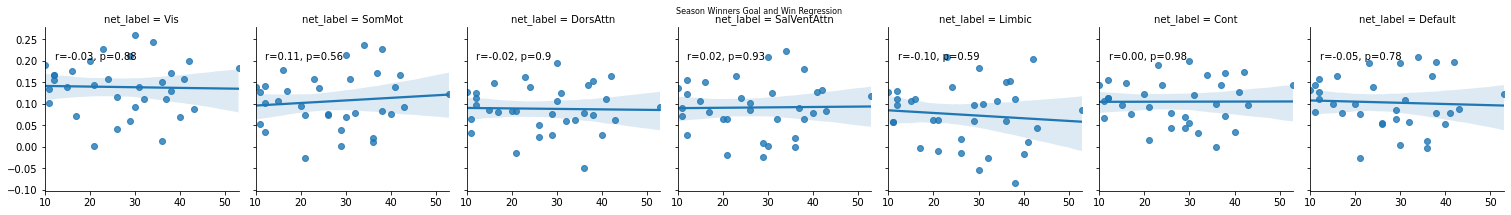

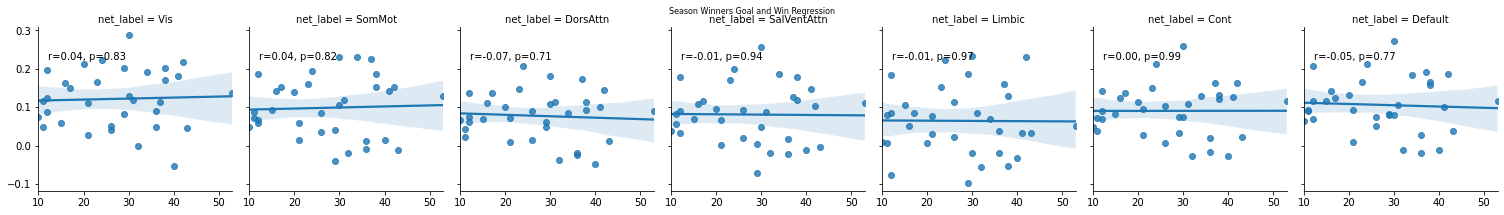

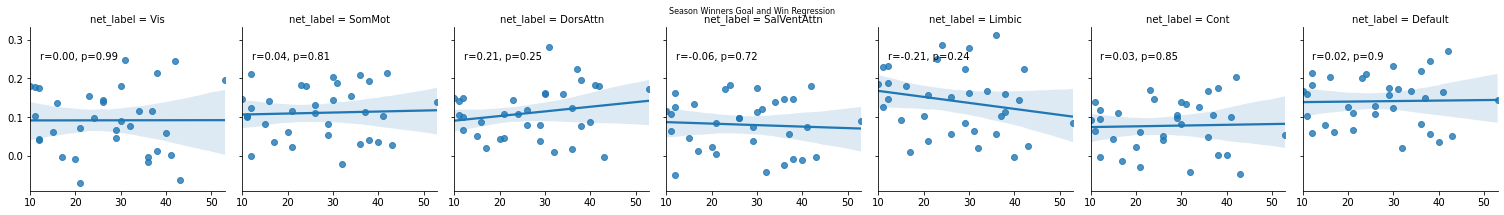

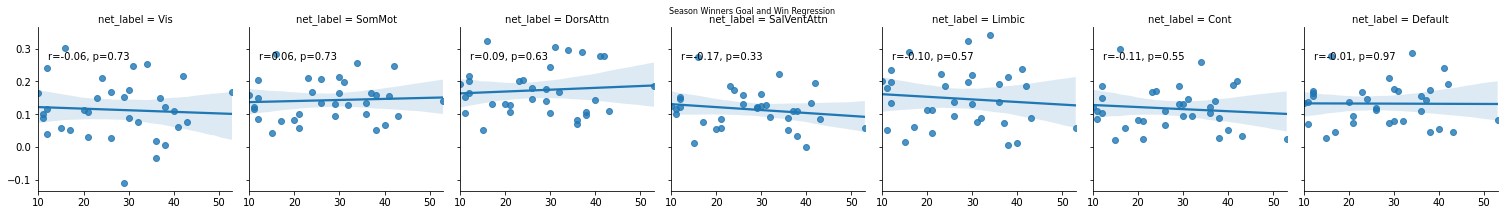

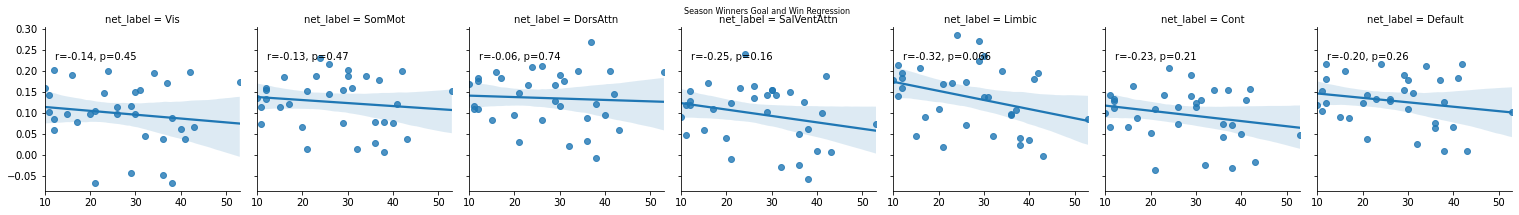

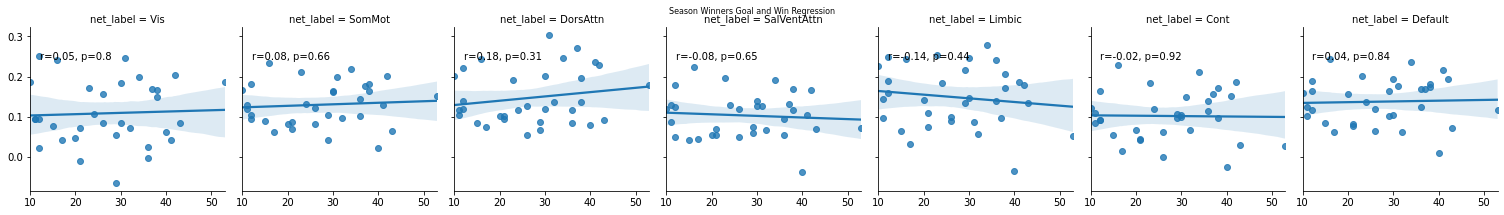

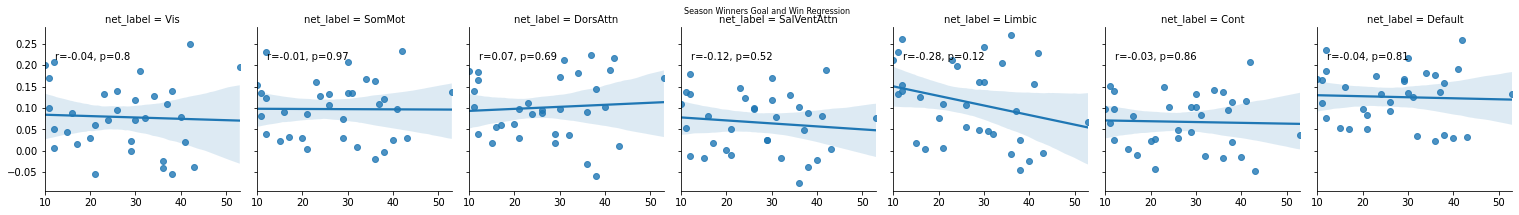

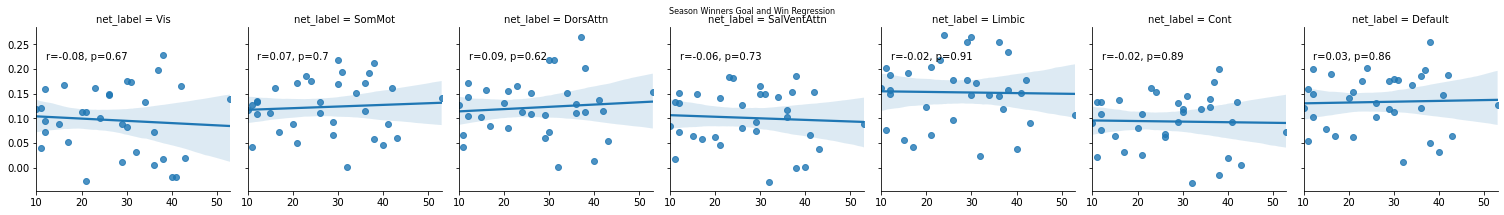

In [18]:
get_final_plots(M12_LH_grad1_l)
get_final_plots(M12_LH_grad1_s)
get_final_plots(M12_LH_grad2_l)
get_final_plots(M12_LH_grad2_s)
get_final_plots(M12_LH_grad3_l)
get_final_plots(M12_LH_grad3_s)

get_final_plots(M12_RH_grad1_l)
get_final_plots(M12_RH_grad1_s)
get_final_plots(M12_RH_grad2_l)
get_final_plots(M12_RH_grad2_s)
get_final_plots(M12_RH_grad3_l)
get_final_plots(M12_RH_grad3_s)



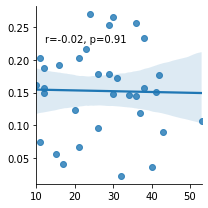

In [19]:
def get_single_cor_plots(df):
    g = sns.lmplot(x='MDS-UPDRS_Total', y='Limbic', data=df, height=3, aspect=1)

    def annotate(data, **kws):
        r, p = sp.stats.pearsonr(data['MDS-UPDRS_Total'], data['Limbic'])
        ax = plt.gca()
        ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
                transform=ax.transAxes)
        
    g.map_dataframe(annotate)
    plt.show()

def get_single_plots(df):
    df_concated = pd.concat([pd_with_updrs, df], axis=1)
    df_sorted = df_concated.drop(['subj', 'group','age_at_baseline'], axis = 1)
    df_sorted = remove_outliers(df_sorted)
    #df_flat = get_flat_df(df_sorted)
    get_single_cor_plots(df_sorted)
get_single_plots(M12_RH_grad3_s)

In [20]:
emb_M24_L = "../../derivatives/analysis/functional/gradients/bs_emb/aligned_emb_sbctx_LH_Month24.pickle"
M24_LH_grad1_l,M24_LH_grad1_s = get_subj_net_df(emb_M24_L,'Month24','LH','1')
M24_LH_grad2_l,M24_LH_grad2_s = get_subj_net_df(emb_M24_L,'Month24','LH','2')
M24_LH_grad3_l,M24_LH_grad3_s = get_subj_net_df(emb_M24_L,'Month24','LH','3')

emb_M24_R = "../../derivatives/analysis/functional/gradients/bs_emb/aligned_emb_sbctx_RH_Month24.pickle"
M24_RH_grad1_l,M24_RH_grad1_s = get_subj_net_df(emb_M24_R,'Month24','RH','1')
M24_RH_grad2_l,M24_RH_grad2_s = get_subj_net_df(emb_M24_R,'Month24','RH','2')
M24_RH_grad3_l,M24_RH_grad3_s = get_subj_net_df(emb_M24_R,'Month24','RH','3')

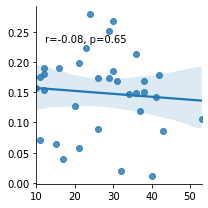

In [21]:
get_single_plots(M24_RH_grad3_s)

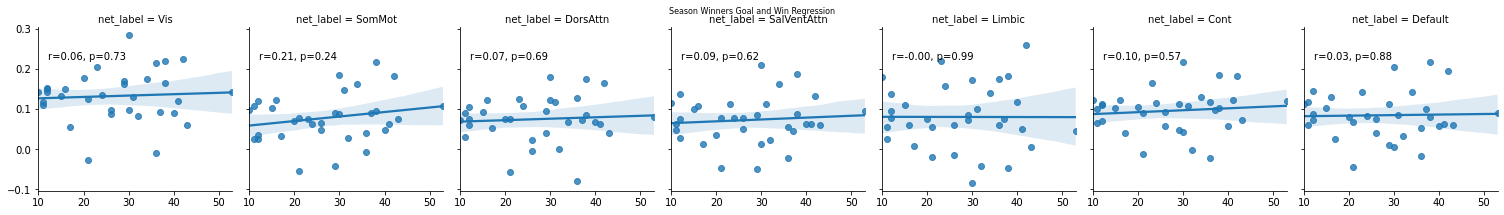

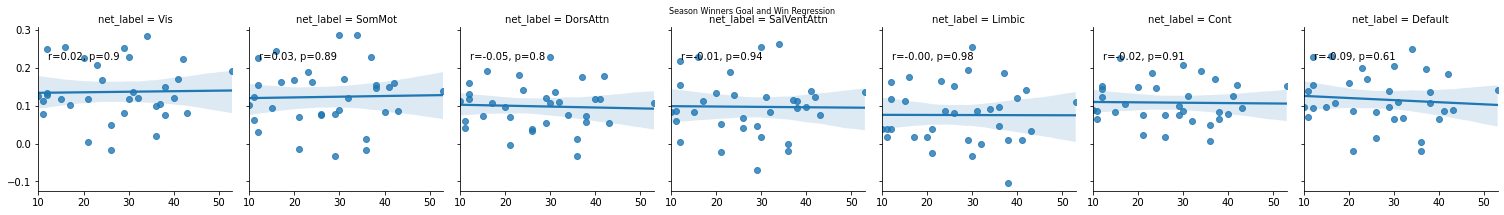

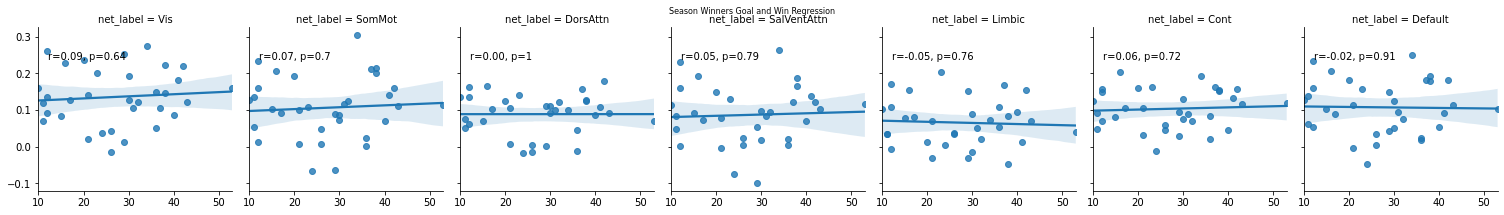

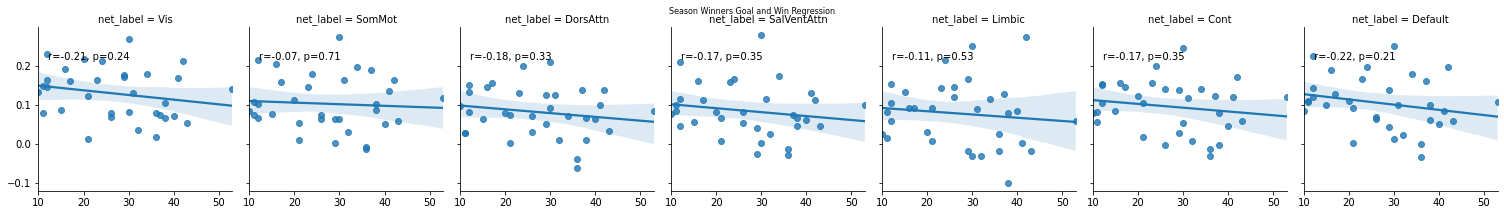

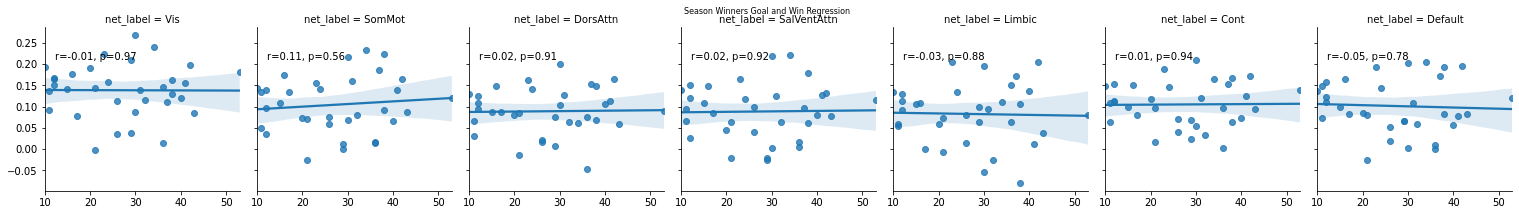

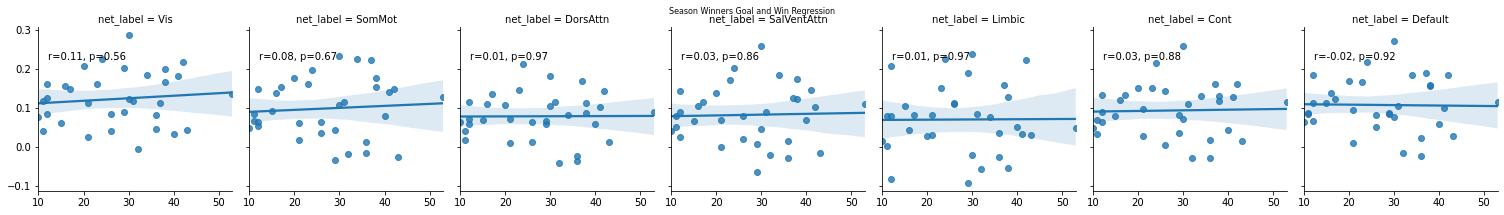

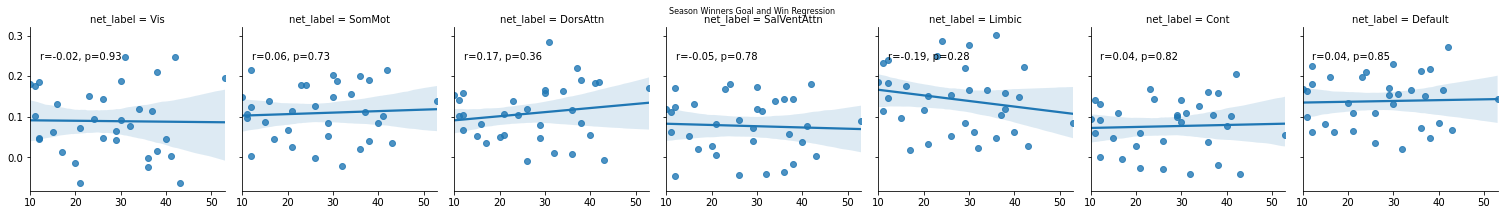

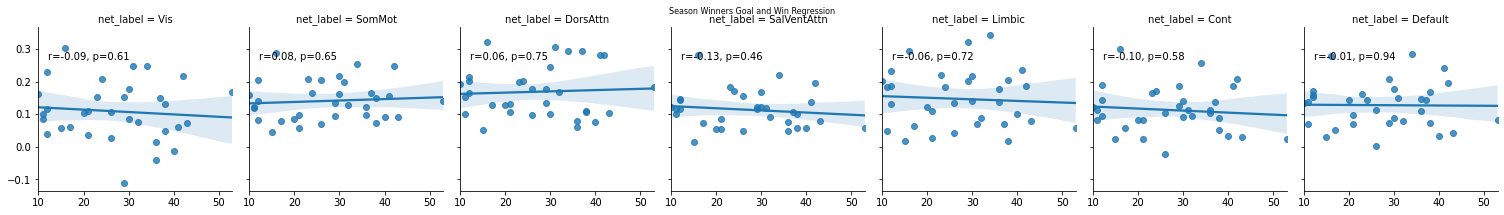

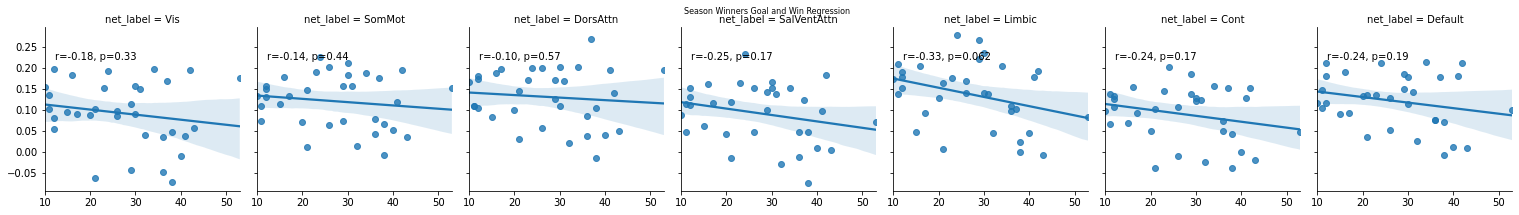

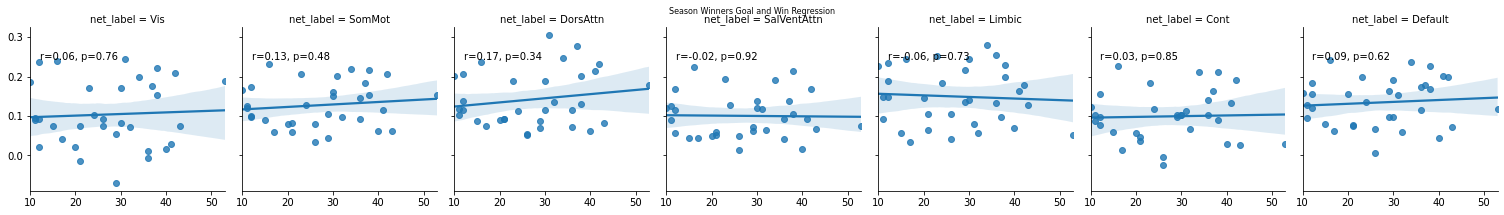

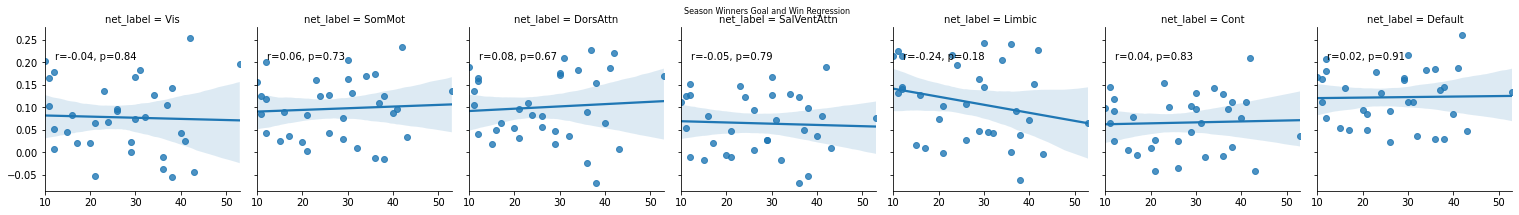

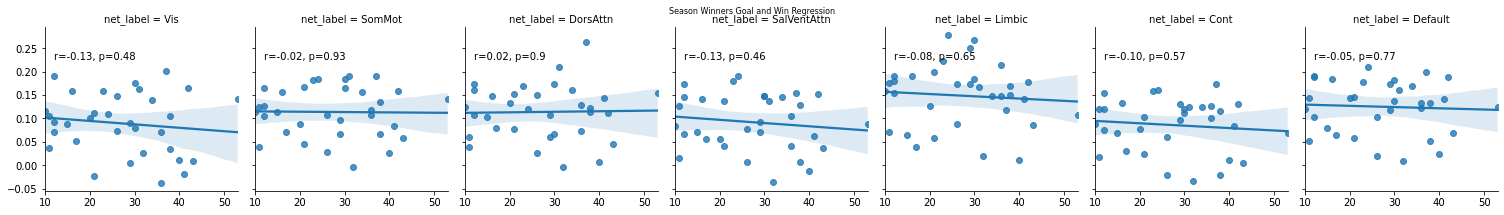

In [22]:
get_final_plots(M24_LH_grad1_l)
get_final_plots(M24_LH_grad1_s)
get_final_plots(M24_LH_grad2_l)
get_final_plots(M24_LH_grad2_s)
get_final_plots(M24_LH_grad3_l)
get_final_plots(M24_LH_grad3_s)

get_final_plots(M24_RH_grad1_l)
get_final_plots(M24_RH_grad1_s)
get_final_plots(M24_RH_grad2_l)
get_final_plots(M24_RH_grad2_s)
get_final_plots(M24_RH_grad3_l)
get_final_plots(M24_RH_grad3_s)

In [23]:
df_MoCA = pd.read_csv('../cfg/demographic/cog_change.csv')
df_MoCA["MoCA_12"] = pd.to_numeric(df_MoCA["MoCA_12"], downcast="float")
df_MoCA=df_MoCA.loc[:, ['MoCA_12','MoCA_24']]

df_MoCA['MoCA_diff'] = df_MoCA['MoCA_12'] - df_MoCA['MoCA_24']
df_MoCA = df_MoCA.drop(['MoCA_12', 'MoCA_24'], axis = 1)




In [24]:

def get_comp_cor_plots(df):
    g = sns.lmplot(x='MDS-UPDRS_Total', y='conn_diff', data=df,
                col='net_label', height=3, aspect=1)

    def annotate(data, **kws):
        r, p = sp.stats.pearsonr(data['MDS-UPDRS_Total'], data['conn_diff'])
        ax = plt.gca()
        ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),transform=ax.transAxes)

    #g.savefig(out_path+'M12_vs_M24_grad1_large.png')
    g.map_dataframe(annotate) 
    plt.show()

def get_comp_plots(df12,df24):
    df_concated_12 = pd.concat([pd_with_updrs, df12], axis=1)
    df_concated_24 = pd.concat([pd_with_updrs, df24], axis=1)
    df_sorted_12 = df_concated_12.drop(['subj', 'group','age_at_baseline'], axis = 1)
    df_sorted_24 = df_concated_24.drop(['subj', 'group','age_at_baseline'], axis = 1)
    df_sorted_12 = remove_outliers(df_sorted_12)
    df_sorted_24 = remove_outliers(df_sorted_24)
    df_flat_12 = get_flat_df(df_sorted_12)
    df_flat_24 = get_flat_df(df_sorted_24)

    df_flat_12.rename(columns={'network': 'M12'}, inplace=True)
    df_flat_24.rename(columns={'network': 'M24'}, inplace=True)
    df_flat_24 = df_flat_24.drop(['MDS-UPDRS_Total', 'net_label'], axis = 1)
    #df_flat_12['session']='Month12'
    #df_flat_24['session']='Month24'
    df_12_n_24 = pd.concat([df_flat_12, df_flat_24], axis=1)
    df_12_n_24 = df_12_n_24.dropna()
    df_12_n_24['conn_diff'] = df_12_n_24['M24'] - df_12_n_24['M12']
    get_comp_cor_plots(df_12_n_24)

    return(df_12_n_24)






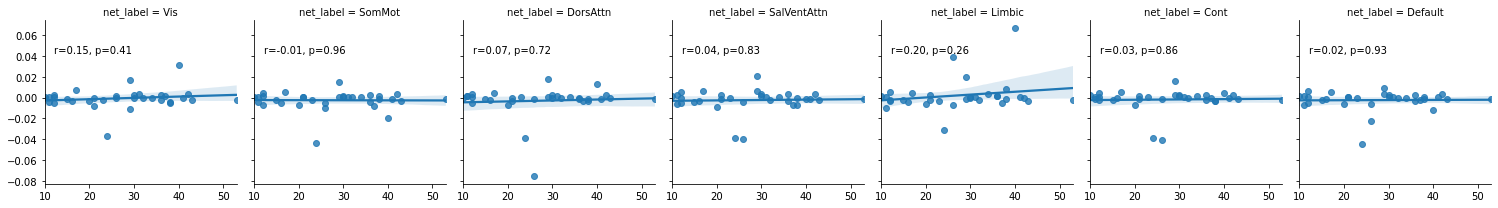

In [25]:
df_12_n_24 = get_comp_plots(M12_LH_grad1_l,M24_LH_grad1_l)

df_12_n_24.to_csv('all.csv',index=False)

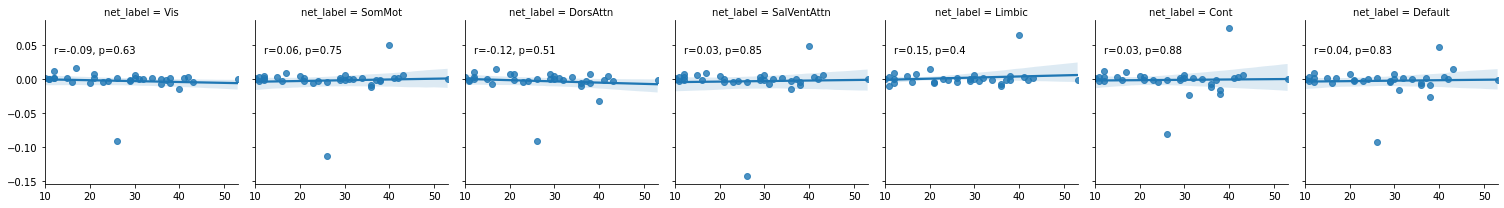

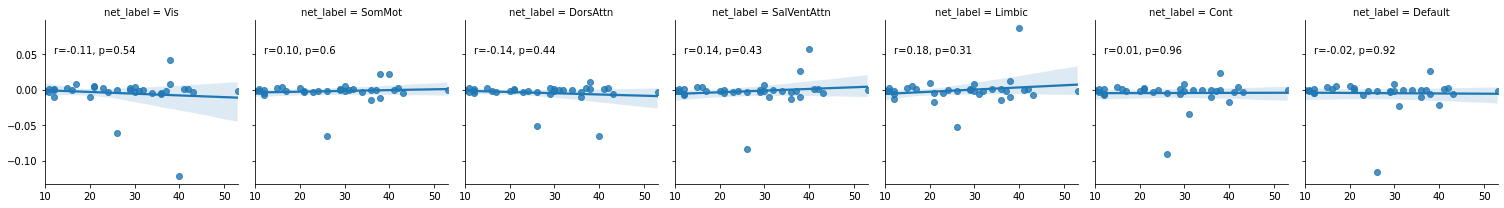

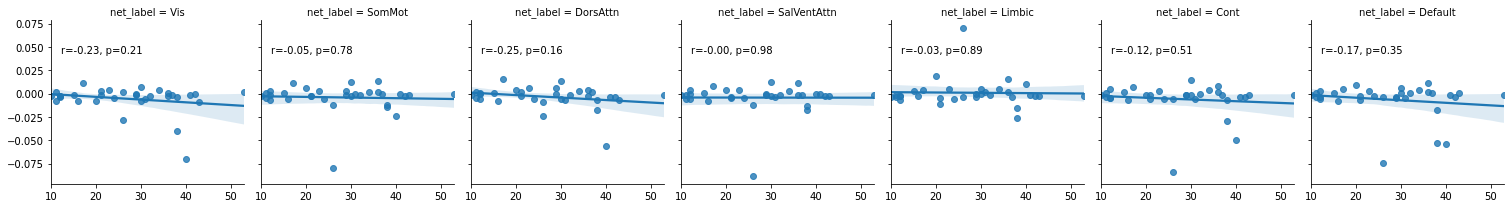

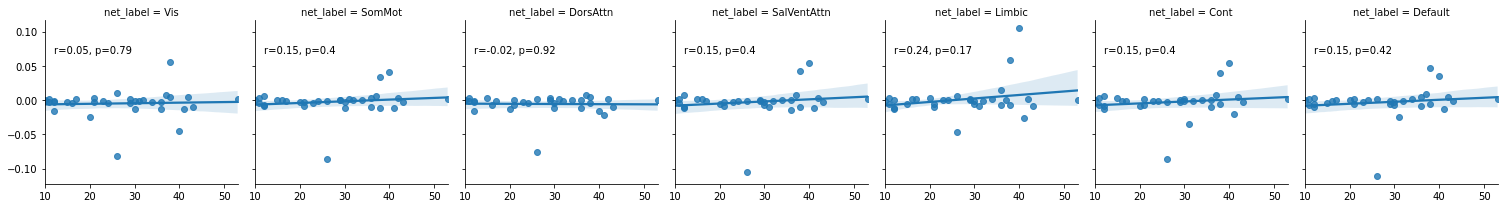

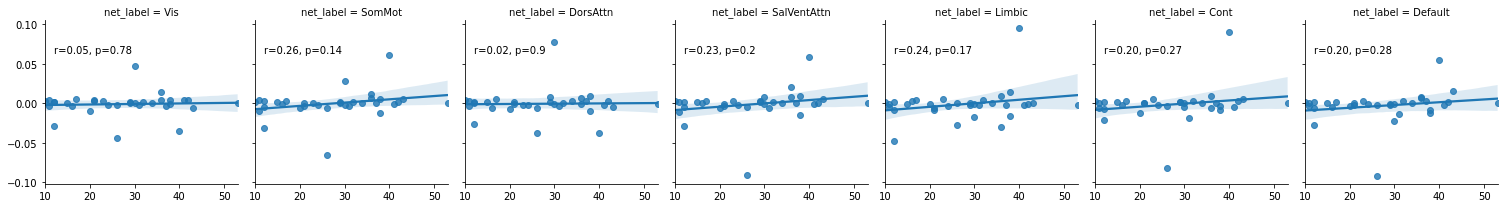

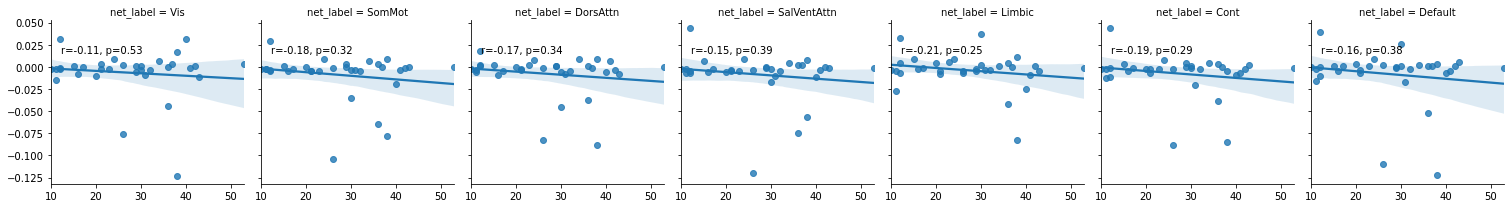

,MDS-UPDRS_Total,M12,net_label,M24,conn_diff
0,26.0,0.146483,Vis,0.148278,0.001795
1,38.0,0.229111,Vis,0.105386,-0.123725
2,38.0,0.017970,Vis,0.034780,0.016811
3,29.0,0.010515,Vis,0.004947,-0.005568
4,30.0,0.175680,Vis,0.176342,0.000662
...,...,...,...,...,...
226,37.0,0.197900,Default,0.199042,0.001142
227,43.0,0.064610,Default,0.069706,0.005096
228,26.0,0.130143,Default,0.020719,-0.109424
229,32.0,0.010554,Default,0.008678,-0.001876


In [26]:
get_comp_plots(M12_RH_grad1_l,M24_RH_grad1_l)
get_comp_plots(M12_RH_grad1_s,M24_RH_grad1_s)
get_comp_plots(M12_RH_grad2_l,M24_RH_grad2_l)
get_comp_plots(M12_RH_grad2_s,M24_RH_grad2_s)
get_comp_plots(M12_RH_grad3_l,M24_RH_grad3_l)
get_comp_plots(M12_RH_grad3_s,M24_RH_grad3_s)

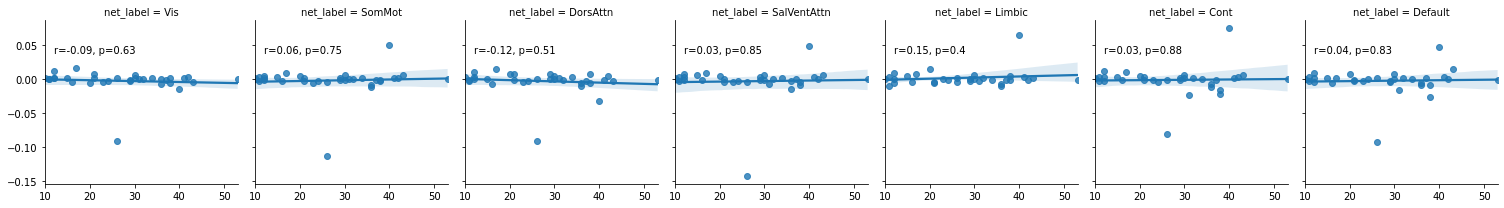

,MDS-UPDRS_Total,M12,net_label,M24,conn_diff
0,26.0,0.144031,Vis,0.144694,0.000663
1,38.0,0.215141,Vis,0.209408,-0.005733
2,38.0,0.013487,Vis,0.014642,0.001155
3,29.0,0.045991,Vis,0.043300,-0.002692
4,30.0,0.181509,Vis,0.186934,0.005425
...,...,...,...,...,...
226,37.0,0.150298,Default,0.151145,0.000848
227,43.0,0.051846,Default,0.066120,0.014274
228,26.0,0.128444,Default,0.035953,-0.092490
229,32.0,0.019857,Default,0.021357,0.001499


In [27]:
get_comp_plots(M12_RH_grad1_l,M24_RH_grad1_l)

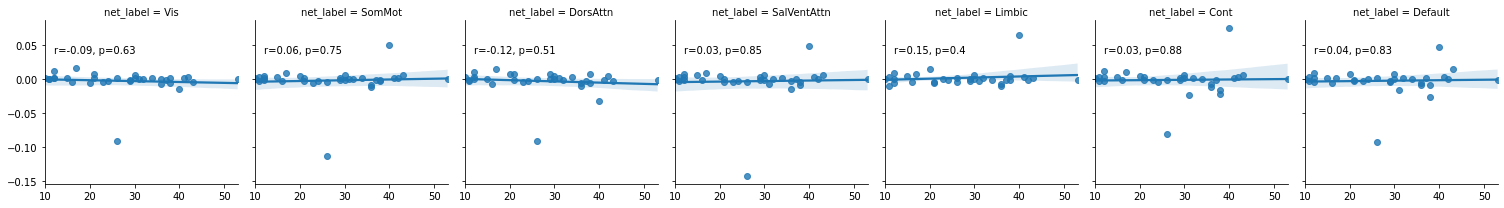

,MDS-UPDRS_Total,M12,net_label,M24,conn_diff
0,26.0,0.144031,Vis,0.144694,0.000663
1,38.0,0.215141,Vis,0.209408,-0.005733
2,38.0,0.013487,Vis,0.014642,0.001155
3,29.0,0.045991,Vis,0.043300,-0.002692
4,30.0,0.181509,Vis,0.186934,0.005425
...,...,...,...,...,...
226,37.0,0.150298,Default,0.151145,0.000848
227,43.0,0.051846,Default,0.066120,0.014274
228,26.0,0.128444,Default,0.035953,-0.092490
229,32.0,0.019857,Default,0.021357,0.001499


In [28]:
get_comp_plots(M12_RH_grad1_l,M24_RH_grad1_l)

In [29]:
df_MoCA = pd.read_csv('../cfg/demographic/cog_change.csv')
df_MoCA["MoCA_12"] = pd.to_numeric(df_MoCA["MoCA_12"], downcast="float")
df_MoCA=df_MoCA.loc[:, ['COGCHG','MoCA_12','MoCA_24']]

df_MoCA['MoCA_diff'] = df_MoCA['MoCA_24'] - df_MoCA['MoCA_12']



In [30]:
def remove_outlier(df_in, col_name):
    for col in col_name:
        q1 = df_in[col].quantile(0.25)
        q3 = df_in[col].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_in = df_in.loc[(df_in[col] > fence_low) & (df_in[col] < fence_high)]
    return df_in

def get_flat_MoCA(df):
    data =[]
    df_o = pd.DataFrame(data, columns=['MoCA_diff', 'network', 'net_label'])

    for i in networks:
        df_i = df.loc[:,['MoCA_diff',i]]
        df_i = df_i.rename(columns={i: "network"})
        df_i['net_label'] = i
        #print(df_i)
        df_o = pd.concat([df_o,df_i],ignore_index=True)
    

    return df_o

def get_comp_cor_plots(df):
    g = sns.lmplot(x='MoCA_diff', y='conn_diff', data=df, col='net_label', height=3, aspect=1)

    def annotate(data, **kws):
        r, p = sp.stats.pearsonr(data['MoCA_diff'], data['conn_diff'])
        ax = plt.gca()
        ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),transform=ax.transAxes)


    #plt.subplots_adjust(top=0.9)
    #plt.suptitle('Season Winners Goal and Win Regression', fontsize = 8)
    
    #g.savefig(out_path+'M12_vs_M24_grad1_large.png')
    g.map_dataframe(annotate) 
    g.set_axis_labels('Change in MoCA','Change in Connectivity')
    plt.show()

def get_comp_plots(df12,df24):
    df_concated_12 = pd.concat([df_MoCA, df12], axis=1)
    
    df_concated_24 = pd.concat([df_MoCA, df24], axis=1)
    
    #df_sorted_12 = df_concated_12.drop(['subj', 'group','age_at_baseline'], axis = 1)
    #df_sorted_24 = df_concated_24.drop(['subj', 'group','age_at_baseline'], axis = 1)
    
    df_sorted_12 = remove_outlier(df_concated_12,networks)
    df_sorted_24 = remove_outlier(df_concated_24,networks)
    
    df_flat_12 = get_flat_MoCA(df_sorted_12)
    df_flat_24 = get_flat_MoCA(df_sorted_24)

    

    df_flat_12.rename(columns={'network': 'M12'}, inplace=True)
    df_flat_24.rename(columns={'network': 'M24'}, inplace=True)
    df_flat_24 = df_flat_24.drop(['MoCA_diff', 'net_label'], axis = 1)
    #df_flat_12['session']='Month12'
    #df_flat_24['session']='Month24'
    df_12_n_24 = pd.concat([df_flat_12, df_flat_24], axis=1)
    df_12_n_24 = df_12_n_24.dropna()
    df_12_n_24['conn_diff'] = df_12_n_24['M24'] - df_12_n_24['M12']

    
    get_comp_cor_plots(df_12_n_24)

    #return(df_12_n_24)

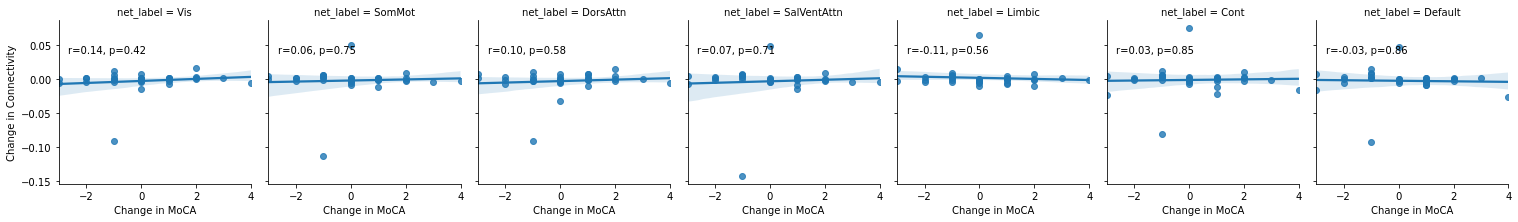

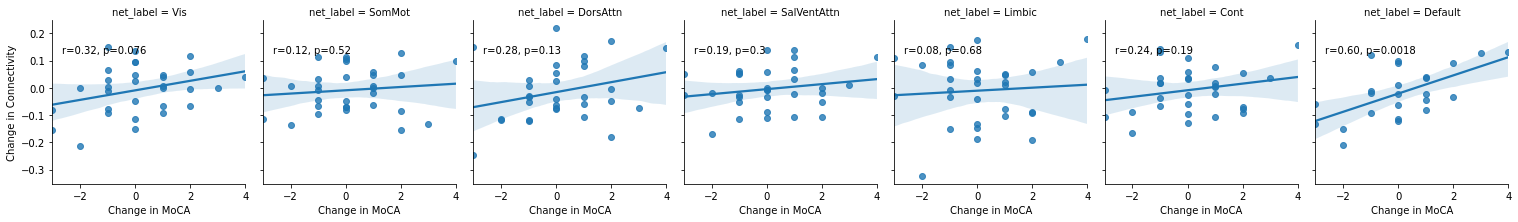

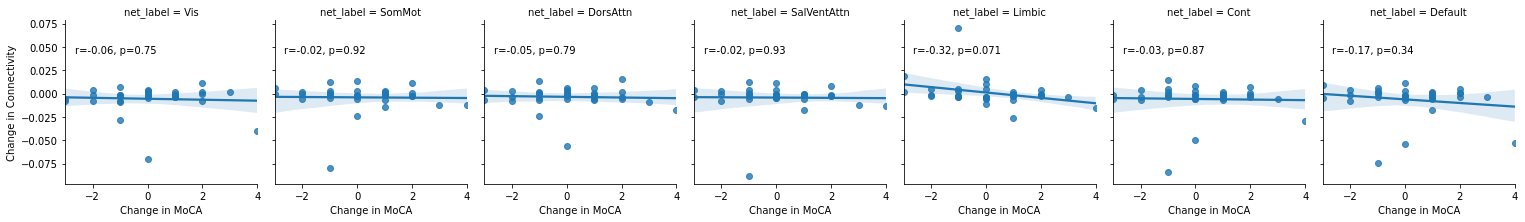

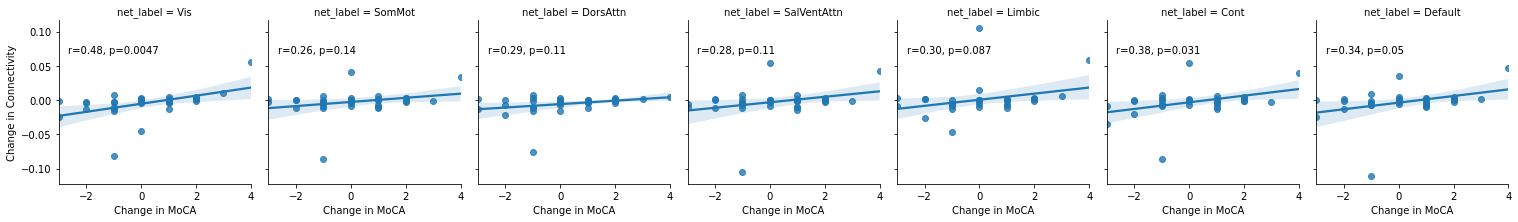

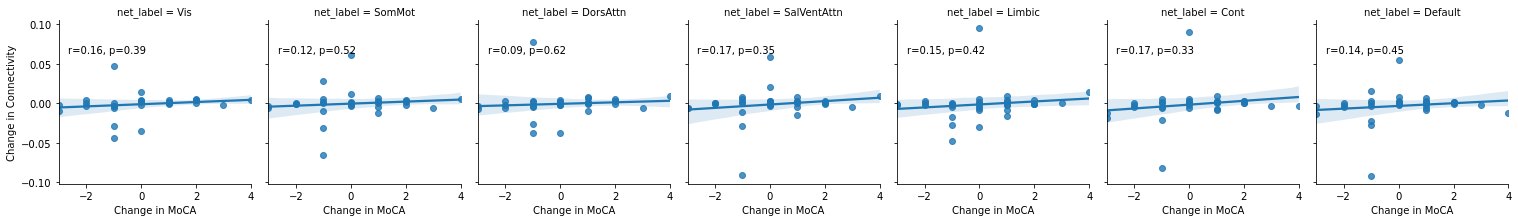

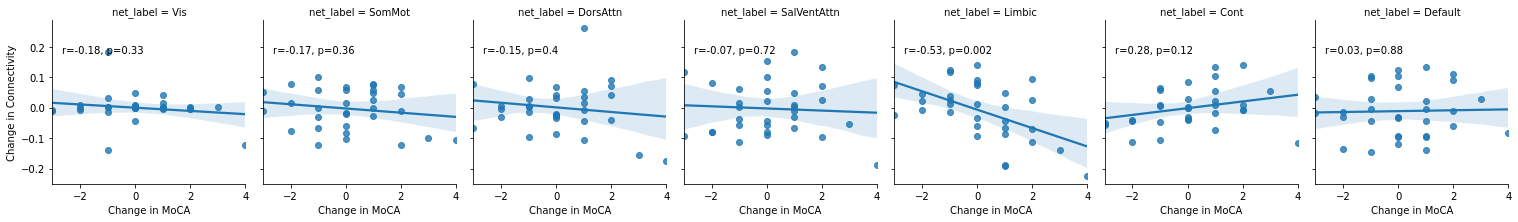

In [31]:
get_comp_plots(M12_RH_grad1_l,M24_RH_grad1_l)
get_comp_plots(M12_RH_grad1_s,M24_RH_grad1_s)
get_comp_plots(M12_RH_grad2_l,M24_RH_grad2_l)
get_comp_plots(M12_RH_grad2_s,M24_RH_grad2_s)
get_comp_plots(M12_RH_grad3_l,M24_RH_grad3_l)
get_comp_plots(M12_RH_grad3_s,M24_RH_grad3_s)

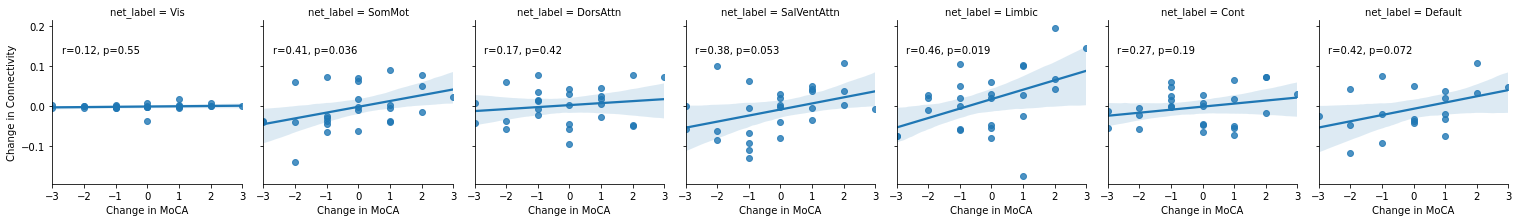

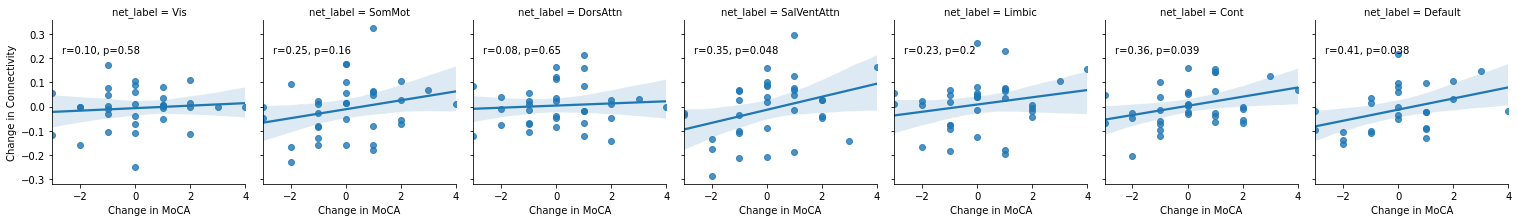

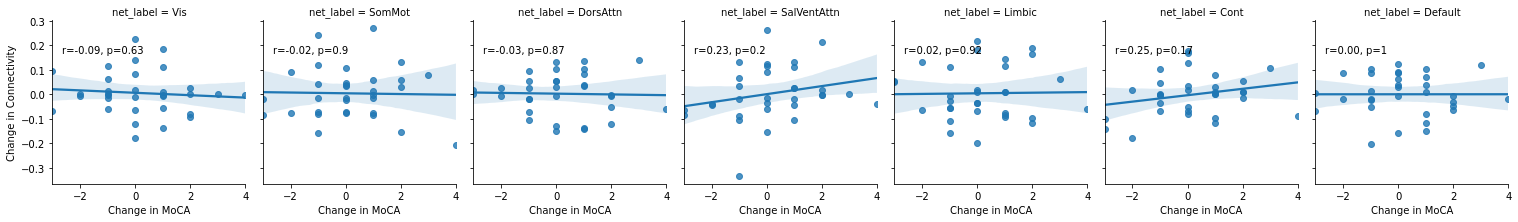

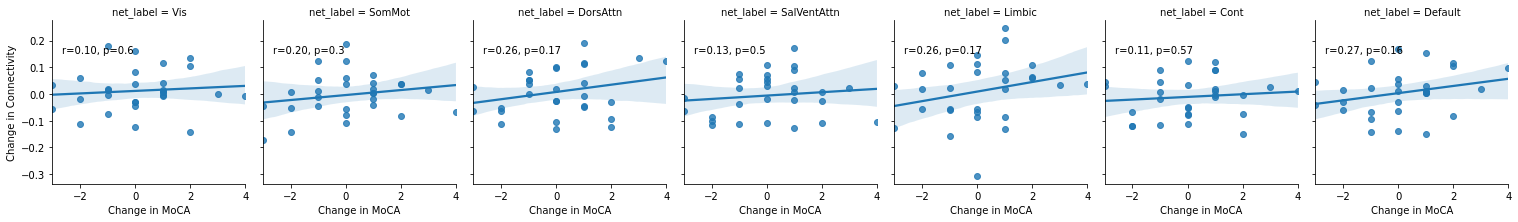

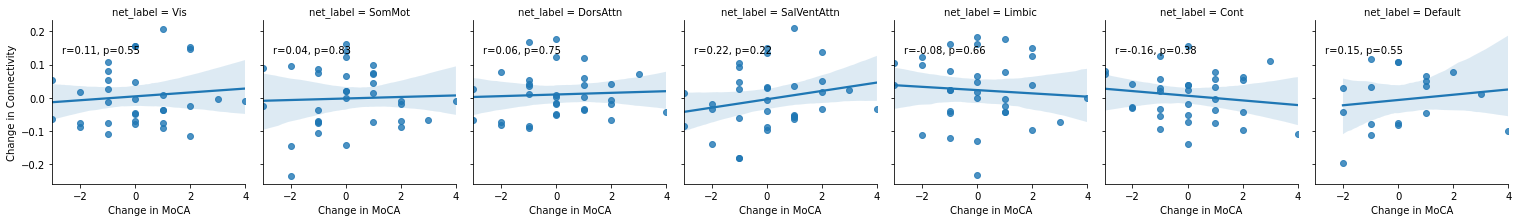

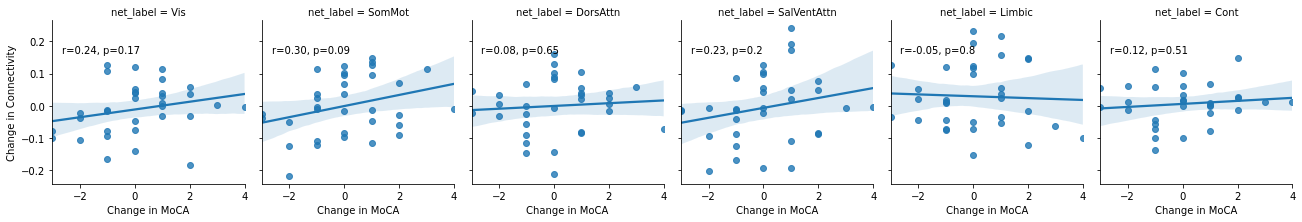

In [32]:
get_comp_plots(M12_LH_grad1_l,M24_LH_grad1_l)
get_comp_plots(M12_LH_grad1_s,M24_LH_grad1_s)
get_comp_plots(M12_LH_grad2_l,M24_LH_grad2_l)
get_comp_plots(M12_LH_grad2_s,M24_LH_grad2_s)
get_comp_plots(M12_LH_grad3_l,M24_LH_grad3_l)
get_comp_plots(M12_LH_grad3_s,M24_LH_grad3_s)

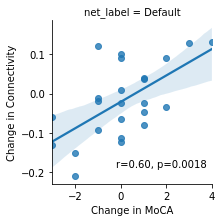

In [33]:
def remove_outlier(df_in, col_name):
    for col in col_name:
        q1 = df_in[col].quantile(0.25)
        q3 = df_in[col].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_in = df_in.loc[(df_in[col] > fence_low) & (df_in[col] < fence_high)]
    return df_in

def get_flat_MoCA(df):
    data =[]
    df_o = pd.DataFrame(data, columns=['MoCA_diff', 'network', 'net_label'])

    for i in networks:
        df_i = df.loc[:,['MoCA_diff',i]]
        df_i = df_i.rename(columns={i: "network"})
        df_i['net_label'] = i
        #print(df_i)
        df_o = pd.concat([df_o,df_i],ignore_index=True)
    

    return df_o

def get_comp_cor_plots(df):
    g = sns.lmplot(x='MoCA_diff', y='conn_diff', data=df, col='net_label', height=3, aspect=1)

    def annotate(data, **kws):
        r, p = sp.stats.pearsonr(data['MoCA_diff'], data['conn_diff'])
        ax = plt.gca()
        ax.text(.4, .1, 'r={:.2f}, p={:.2g}'.format(r, p),transform=ax.transAxes)


    #plt.subplots_adjust(top=0.9)
    #plt.suptitle('Season Winners Goal and Win Regression', fontsize = 8)
    
    #g.savefig(out_path+'M12_vs_M24_grad1_large.png')
    g.map_dataframe(annotate) 
    g.set_axis_labels('Change in MoCA','Change in Connectivity')
    plt.show()

def get_comp_plots(df12,df24,net):
    df_concated_12 = pd.concat([df_MoCA, df12], axis=1)
    
    df_concated_24 = pd.concat([df_MoCA, df24], axis=1)
    
    #df_sorted_12 = df_concated_12.drop(['subj', 'group','age_at_baseline'], axis = 1)
    #df_sorted_24 = df_concated_24.drop(['subj', 'group','age_at_baseline'], axis = 1)
    
    df_sorted_12 = remove_outlier(df_concated_12,networks)
    df_sorted_24 = remove_outlier(df_concated_24,networks)
    
    df_flat_12 = get_flat_MoCA(df_sorted_12)
    df_flat_24 = get_flat_MoCA(df_sorted_24)

    

    df_flat_12.rename(columns={'network': 'M12'}, inplace=True)
    df_flat_24.rename(columns={'network': 'M24'}, inplace=True)
    df_flat_24 = df_flat_24.drop(['MoCA_diff', 'net_label'], axis = 1)
    #df_flat_12['session']='Month12'
    #df_flat_24['session']='Month24'
    df_12_n_24 = pd.concat([df_flat_12, df_flat_24], axis=1)
    df_12_n_24 = df_12_n_24.dropna()
    df_12_n_24['conn_diff'] = df_12_n_24['M24'] - df_12_n_24['M12']
    df_12_n_24 = df_12_n_24.loc[df_12_n_24['net_label'] == net]

    
    get_comp_cor_plots(df_12_n_24)
    return df_12_n_24
    
single_df = get_comp_plots(M12_RH_grad1_s,M24_RH_grad1_s,'Default')

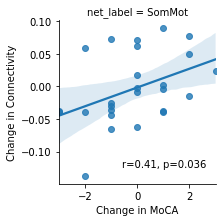

In [34]:
single_df = get_comp_plots(M12_LH_grad1_l,M24_LH_grad1_l,'SomMot')

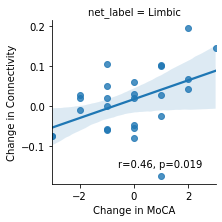

In [35]:
single_df = get_comp_plots(M12_LH_grad1_l,M24_LH_grad1_l,'Limbic')